In [72]:
#Packages
import pandas as pd
import os 
import re
import networkx as nx
import plotly.graph_objects as go
from langdetect import detect, LangDetectException
import unicodedata
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

# Télécharger les ressources NLTK nécessaires
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /Users/antoine/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antoine/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/antoine/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [73]:
df = pd.read_csv('data/pepite_data.csv', sep=',')

In [74]:
def process_names(name):
    """
    Traite un nom pour inverser le premier et le dernier élément s'il y a plus d'une partie.
    
    Args:
    name (str): Nom complet sous forme de chaîne.

    Returns:
    str: Nom avec le premier et le dernier élément inversés.
    """
    parts = name.split(',')
    parts = [part.strip() for part in parts]
    if len(parts) > 1:
        first, last = parts[0], parts[-1]
        middle = parts[1:-1]
        parts = [last] + middle + [first]
    return ' '.join(parts)

# Colonnes à traiter pour l'inversion des noms
columns_to_process = ['authors', 'director', 'jury']

# Appliquer la fonction aux colonnes spécifiées
for column in columns_to_process:
    df[column] = df[column].apply(lambda x: ' ; '.join([process_names(name) for name in x.split(' ; ')]))

def update_parcours(row):
    """
    Met à jour les colonnes 'speciality' et 'parcours'. 
    Si 'parcours' est vide ou contient 'No parcours found' et que 'speciality' contient plusieurs parties,
    déplace la deuxième partie de 'speciality' vers 'parcours'.

    Args:
    row (pd.Series): Une ligne du DataFrame.

    Returns:
    pd.Series: La ligne mise à jour.
    """
    parts = [part.strip() for part in row['speciality'].split(';')]
    if len(parts) > 1:
        row['speciality'] = parts[0]  # Conserver uniquement la première partie
        if not row['parcours'] or row['parcours'] == "No parcours found":
            row['parcours'] = parts[1]  # Déplacer la deuxième partie vers parcours si nécessaire
    return row

# Appliquer la fonction à chaque ligne
df = df.apply(update_parcours, axis=1)

def update_dates(date_str):
    """
    Met à jour les dates dans la colonne 'date'.
    Si la date est au format '//XXXX', elle est transformée en '01/01/XXXX'.

    Args:
    date_str (str): Date sous forme de chaîne.

    Returns:
    str: Date formatée.
    """
    if re.match(r'^//\d{4}$', date_str):
        return f'01/01/{date_str[2:]}'
    return date_str

# Appliquer la fonction à la colonne 'date'
df['date'] = df['date'].apply(update_dates)

In [75]:
print(df.head())

                                               title           authors  \
0  Améliorer notre santé grâce à l’amélioration d...   Robin Scholaert   
1  Connectivité et interconnectivité des disposit...     Lucas Ravenet   
2  De la sous-traitance des services dans le mili...     Léa Petitjean   
3  De quelles manières les dispositifs médicaux c...  Sadjedah Allaoui   
4  Effets du tabac et de l’alcool sur le cancer d...   Clara Ed-Derbal   

                                            keywords              speciality  \
0  Cocktail de polluants ; santé humaine ; sensib...  Ingénierie de la santé   
1  Dispositifs médicaux connectés ; soins critiqu...  Ingénierie de la santé   
2  Sous-traitance pharmaceutique ; recherche clin...  Ingénierie de la santé   
3  Wearables ; déserts médicaux ; hôpital ; parco...  Ingénierie de la santé   
4  Cancer de l’œsophage ; carcinome épidermoïde e...  Ingénierie de la santé   

                      director                                     jury  \

In [76]:
import networkx as nx
import pandas as pd
import plotly.graph_objs as go
from itertools import cycle
from collections import defaultdict

# Conversion de la colonne jury en liste de membres
df['jury'] = df['jury'].apply(lambda x: x.split(' ; '))

# Création du graphe à partir de la liste des arêtes dans le dataframe
edges = []
for i, row in df.iterrows():
    director = row['director']
    for jury_member in row['jury']:
        edges.append((director, jury_member))

G = nx.Graph()
G.add_edges_from(edges)

# Ajout des attributs de nœud (spécialité, rôle, parcours)
for i, row in df.iterrows():
    G.nodes[row['director']]['parcours'] = row['parcours']
    G.nodes[row['director']]['role'] = 'Director'
    for jury_member in row['jury']:
        G.nodes[jury_member]['parcours'] = row['parcours']
        G.nodes[jury_member]['role'] = 'Jury'

# Assurez-vous que tous les nœuds ont un attribut 'parcours'
for node in G.nodes():
    if 'parcours' not in G.nodes[node]:
        G.nodes[node]['parcours'] = 'unknown'  # Valeur par défaut

# Calcul des degrés des nœuds
degrees = dict(G.degree())

# Calculer les directeurs les plus prolifiques par parcours
directors_by_parcours = defaultdict(list)
for director, degree in degrees.items():
    if G.nodes[director]['role'] == 'Director':
        parcours = G.nodes[director]['parcours']
        directors_by_parcours[parcours].append((director, degree))

# Sélectionner les 5 directeurs les plus prolifiques par parcours
top_directors_by_parcours = {}
for parcours, directors in directors_by_parcours.items():
    top_directors_by_parcours[parcours] = sorted(directors, key=lambda x: x[1], reverse=True)[:5]

# Créer un ensemble avec ces directeurs
top_directors_set = set()
for directors in top_directors_by_parcours.values():
    top_directors_set.update([director for director, degree in directors])

# Créer un sous-graphe avec ces directeurs et leurs connexions
subgraph_nodes = set()
for director in top_directors_set:
    subgraph_nodes.add(director)
    subgraph_nodes.update(G.neighbors(director))

G_sub = G.subgraph(subgraph_nodes)

# Recalcul des degrés des nœuds dans le sous-graphe
degrees_sub = dict(G_sub.degree())

# Normalisation de la taille des nœuds pour l'affichage
max_degree = max(degrees_sub.values())
min_size = 10
max_size = 50  # Augmenté pour une meilleure visualisation
node_size = {node: min_size + (max_size - min_size) * (degree / max_degree) for node, degree in degrees_sub.items()}

# Palette de couleurs pour les spécialités
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
specialty_colors = {specialty: color for specialty, color in zip(set(nx.get_node_attributes(G_sub, 'parcours').values()), colors)}

# Positions des nœuds
pos = nx.spring_layout(G_sub, k=1)  # Augmenter le paramètre k pour un graphe plus aéré

# Tracé des arêtes
edge_trace = go.Scatter(
    x=[], y=[], 
    line=dict(width=0.5, color='#888'), 
    hoverinfo='none', 
    mode='lines')

for edge in G_sub.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += (x0, x1, None)
    edge_trace['y'] += (y0, y1, None)

# Tracé des nœuds
node_trace = go.Scatter(
    x=[], y=[], 
    text=[], 
    mode='markers+text', 
    hoverinfo='text', 
    marker=dict(
        showscale=True, 
        colorscale='YlGnBu', 
        size=[node_size[node] for node in G_sub.nodes()],
        color=[specialty_colors[G_sub.nodes[node]['parcours']] for node in G_sub.nodes()], 
        line_width=2))

for node in G_sub.nodes():
    x, y = pos[node]
    node_trace['x'] += (x,)
    node_trace['y'] += (y,)
    if node in top_directors_set:
        node_trace['text'] += (f"{node} ({G_sub.nodes[node]['parcours']})",)
    else:
        node_trace['text'] += (f"",)  # Hide text for other nodes

# Configuration de la figure
fig = go.Figure(data=[edge_trace, node_trace], layout=go.Layout(
    title='Réseau des Directeurs de Jury les plus Prolifiques par Parcours',
    showlegend=True, 
    hovermode='closest', 
    margin=dict(b=0, l=0, r=0, t=40), 
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

fig.show()


In [77]:
def update_graph_data(data):
    if not data:
        return html.Div("No data available.")

    # Check for expected columns and handle data
    df = pd.DataFrame(data["df2"])
    if 'director' not in df.columns or 'jury' not in df.columns:
        return html.Div("DataFrame does not contain required columns.")

    # Create the NetworkX graph
    G = nx.from_pandas_edgelist(df, 'director', 'jury')

    # Apply a layout algorithm
    pos = nx.fruchterman_reingold_layout(G, k=0.1, iterations=2000, threshold=1e-10)

    # Convert the NetworkX graph to Cytoscape format
    cy = nx.cytoscape_data(G)

    # Add labels to the nodes
    for n in cy["elements"]["nodes"]:
        for k, v in n.items():
            v["label"] = v.pop("value")

    # Add coordinates from the layout
    SCALING_FACTOR = 1000
    for n, p in zip(cy["elements"]["nodes"], pos.values()):
        n["position"] = {"x": int(p[0] * SCALING_FACTOR), "y": int(p[1] * SCALING_FACTOR)}

    # Create the list of elements for Cytoscape
    elements = cy["elements"]["nodes"] + cy["elements"]["edges"]

    # Create and return the Cytoscape component
    cyto_graph = cyto.Cytoscape(
        id='network-graph',
        elements=elements,
        layout={'name': 'preset'},  # "preset" to use the pos coords
        style={'width': '100%', 'height': '800px'},
    )

    return cyto_graph

In [78]:
def preprocess_keyword_for_detection(keyword):
    """
    Prétraite un mot clé pour la détection de langue en conservant les accents.
    
    Args:
        keyword (str): Le mot clé à prétraiter.
    
    Returns:
        str: Le mot clé prétraité.
    """
    # Conversion en minuscules
    keyword = keyword.lower()
    # Suppression de la ponctuation
    keyword = keyword.translate(str.maketrans('', '', string.punctuation))
    # Retourne le mot clé prétraité
    return keyword

def detect_language(keyword):
    try:
        return detect(keyword)
    except LangDetectException:
        return 'unknown'

def ensure_french_or_english(lang, keyword):
    if lang in ['fr', 'en']:
        return lang
    else:
        # Re-check or default to 'en'
        try:
            # A simplified detection without punctuation
            simplified_keyword = preprocess_keyword_for_detection(keyword)
            simplified_lang = detect(simplified_keyword)
            if simplified_lang in ['fr', 'en']:
                return simplified_lang
        except LangDetectException:
            pass
        # Default to English if not detected correctly
        return 'en'

def separate_keywords(row):
    french_keywords = []
    english_keywords = []
    
    if pd.isna(row['keywords']):
        return "", "", row['director']
    
    keywords = row['keywords'].split(';')
    for keyword in keywords:
        original_keyword = keyword.strip()
        keyword_processed = preprocess_keyword_for_detection(original_keyword)
        
        lang = detect_language(keyword_processed)
        lang = ensure_french_or_english(lang, original_keyword)
        
        if lang == 'fr':
            french_keywords.append(original_keyword)
        elif lang == 'en':
            english_keywords.append(original_keyword)
    
    return "; ".join(french_keywords), "; ".join(english_keywords), row['director']

def process_keywords(df):
    """
    Applique la fonction de séparation des mots-clés à chaque ligne de la colonne 'keywords'.
    
    Args:
        df (pd.DataFrame): Le DataFrame contenant les colonnes 'keywords' et 'director'.
    
    Returns:
        pd.DataFrame: Le DataFrame avec trois colonnes supplémentaires 'french_keywords', 'english_keywords', et 'director'.
    """
    
    df[['french_keywords', 'english_keywords', 'director']] = df.apply(
        lambda row: pd.Series(separate_keywords(row)), axis=1
    )
    
    df['year'] = pd.to_datetime(df['date'], errors='coerce').dt.year
    all_keywords = []

    for _, row in df.iterrows():
        year = row['year']
        director = row['director']
        keywords = row['french_keywords']
        if pd.notna(keywords):
            for keyword in keywords.split(';'):
                keyword = keyword.strip()
                all_keywords.append((keyword, year, director))

    return all_keywords



In [99]:

print(str(process_keywords(df)))

[('Cocktail de polluants', 2023.0, 'Florent Occelli'), ('santé humaine', 2023.0, 'Florent Occelli'), ('opportunités commerciales', 2023.0, 'Florent Occelli'), ('qualité d’air intérieur, Pollutant cocktail', 2023.0, 'Florent Occelli'), ('Dispositifs médicaux connectés', nan, 'Régis Logier'), ('soins critiques', nan, 'Régis Logier'), ('interconnectivité', nan, 'Régis Logier'), ('prise en charge', nan, 'Régis Logier'), ('patient care', nan, 'Régis Logier'), ('Sous-traitance pharmaceutique', nan, 'Hélène Gorge'), ('recherche clinique', nan, 'Hélène Gorge'), ('donneur d’ordre', nan, 'Hélène Gorge'), ('sous-traitant', nan, 'Hélène Gorge'), ('sponsor', nan, 'Hélène Gorge'), ('déserts médicaux', nan, 'Christian Vilhelm'), ('parcours de santé', nan, 'Christian Vilhelm'), ('Cancer de l’œsophage', nan, 'María-José Garcia-Fernandez'), ('facteurs socio-économiques, Oesophageal cancer', nan, 'María-José Garcia-Fernandez'), ('Insuffisance cardiaque', 2023.0, 'Hélène Gorge'), ('gestion', 2023.0, 'Hélè

In [114]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

pairs_df = pd.DataFrame(process_keywords(df), columns=['french_keywords', 'date', 'director'])  

def prepare_data(pairs_df):
    # Group keywords by director
    grouped_data = pairs_df.groupby('director')['french_keywords'].apply(list).reset_index()
    
    # Remove empty lists and clean keywords
    grouped_data['french_keywords'] = grouped_data['french_keywords'].apply(lambda x: [kw for kw in x if kw])
    grouped_data = grouped_data[grouped_data['french_keywords'].map(len) > 0]
    
    # Check the prepared data
    print("Grouped Data:", grouped_data.head())  # Print the first few entries for verification
    
    # Use TransactionEncoder to transform the data into the format needed for association rule learning
    te = TransactionEncoder()
    te_ary = te.fit(grouped_data['french_keywords']).transform(grouped_data['french_keywords'])
    df_trans = pd.DataFrame(te_ary, columns=te.columns_)
    
    return df_trans, grouped_data

df_trans, grouped_data = prepare_data(pairs_df)

Grouped Data:                               director  \
2                       Adrien Laurent   
4                          Albane Boin   
5                    Alexandre Wallard   
6  Alexandre Wallard ; Dominique Moyal   
7                      Amandine Pollet   

                                     french_keywords  
2  [Risques psychosociaux, prévention, pratiques ...  
4  [Résidences autonomie, Projet personnalisé, Bi...  
5  [Endométriose, problème de santé publique, err...  
6  [Recherche clinique, dermo-cosmétique, effets ...  
7  [prise en charge, évolution, Nursing homes, ev...  
   "Open Data", Télémédecine, Santé publique -- Bases de données, Données massives, Données ouvertes  \
0                                              False                                                   
1                                              False                                                   
2                                              False                                       

In [110]:
print(df_trans.head())

   "Open Data", Télémédecine, Santé publique -- Bases de données, Données massives, Données ouvertes  \
0                                              False                                                   
1                                              False                                                   
2                                              False                                                   
3                                              False                                                   
4                                              False                                                   

   Absentéisme  Accessibilité numérique  Accessible à tous  \
0        False                    False              False   
1        False                    False              False   
2        False                    False              False   
3        False                    False              False   
4        False                    False              False   

  

In [116]:
def apply_apriori(df_trans, min_support=0.05, min_confidence=0.3):
    frequent_itemsets = apriori(df_trans, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    
    return frequent_itemsets, rules

# Apply Apriori with adjusted parameters
frequent_itemsets, rules = apply_apriori(df_trans, min_support=0.05, min_confidence=0.5)
print(rules.head())

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction, zhangs_metric]
Index: []


In [119]:
# Inspect the association rules
frequent_itemsets, rules = apply_apriori(df_trans, min_support=0.01, min_confidence=0.1)

print(frequent_itemsets)
print(rules)


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x104f72790>>
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [ ]:
import pandas as pd
import plotly.graph_objects as go

def process_keywords(df):
    """
    Processes the DataFrame to extract and separate keywords into French and English, then adds the year from the date.
    Args:
        df (pd.DataFrame): DataFrame containing 'keywords' and 'date' columns.
    Returns:
        list: List of dictionaries with 'french_keywords' and 'year'.
    """
    if 'keywords' not in df.columns or 'date' not in df.columns:
        raise ValueError("DataFrame must include 'keywords' and 'date' columns")
    
    df[['french_keywords', 'english_keywords']] = df['keywords'].apply(
        lambda row: pd.Series(separate_keywords(row))
    )
    df['year'] = pd.to_datetime(df['date'], errors='coerce').dt.year
    all_keywords = []
    for _, row in df.iterrows():
        year = row['year']
        keywords = row['french_keywords']
        if pd.notna(keywords):
            for keyword in keywords.split(';'):
                all_keywords.append({'french_keywords': keyword.strip(), 'year': year})
    return all_keywords

def get_processed_data(df):
    """
    Processes the DataFrame and returns keyword counts grouped by year.
    Args:
        df (pd.DataFrame): DataFrame containing the raw data.
    Returns:
        pd.DataFrame: DataFrame with 'year', 'french_keywords', and 'count'.
    """
    all_keywords = process_keywords(df)
    df_keywords = pd.DataFrame(all_keywords)

    # Ensure 'year' column exists before attempting to drop NaNs
    if 'year' in df_keywords.columns:
        df_keywords = df_keywords.dropna(subset=['year'])
    
    if df_keywords.empty or not {'french_keywords', 'year'}.issubset(df_keywords.columns):
        return pd.DataFrame()

    keyword_counts = df_keywords.groupby(['year', 'french_keywords']).size().reset_index(name='count')
    return keyword_counts

def update_dropdown_and_graph(data):
    """
    Updates the dropdown options and the graph based on the processed data.
    Args:
        data (dict): Dictionary containing the raw data.
    Returns:
        tuple: Dropdown options, top keywords, and the updated figure.
    """
    if data is None:
        return [], [], go.Figure()

    df = pd.DataFrame(data)
    processed_data = get_processed_data(df)
    
    if processed_data.empty or not {'french_keywords', 'year', 'count'}.issubset(processed_data.columns):
        return [], [], go.Figure()
    
    # Update dropdown options and top keywords
    keywords = processed_data['french_keywords'].unique()
    options = [{'label': kw, 'value': kw} for kw in keywords]
    top_keywords = processed_data.groupby('french_keywords')['count'].sum().nlargest(10).index.tolist()
    
    # Update graph with enhanced styling
    fig = go.Figure()
    for keyword in top_keywords:
        df_keyword = processed_data[processed_data['french_keywords'] == keyword]
        fig.add_trace(go.Scatter(
            x=df_keyword['year'], y=df_keyword['count'],
            mode='lines+markers',
            name=keyword,
            line=dict(width=2),
            marker=dict(size=6)
        ))
    
    # Set x-axis ticks to represent each year
    years = processed_data['year'].unique()
    fig.update_layout(
        title='Mots-clés en français les plus tendances par année',
        xaxis=dict(title='Année', tickvals=years, showgrid=True, gridcolor='lightgrey'),
        yaxis=dict(title='Occurrences', showgrid=True, gridcolor='lightgrey'),
        plot_bgcolor='white',
        hovermode='x unified',
        legend=dict(title='Keywords', orientation='v', x=1.02, y=1, bgcolor='rgba(255, 255, 255, 0.5)'),
        margin=dict(l=40, r=40, t=40, b=40)
    )
    
    return options, top_keywords, fig


# Simulate function call
options, top_keywords, fig = update_dropdown_and_graph(df)
print("Dropdown Options:")
print(options)
print("Top Keywords:")
print(top_keywords)
fig.show()


Dropdown Options:
[{'label': '', 'value': ''}, {'label': '"Open Data", Télémédecine, Santé publique -- Bases de données, Données massives, Données ouvertes', 'value': '"Open Data", Télémédecine, Santé publique -- Bases de données, Données massives, Données ouvertes'}, {'label': 'Accessible à tous', 'value': 'Accessible à tous'}, {'label': 'Adaptation du système de soins', 'value': 'Adaptation du système de soins'}, {'label': 'Agriculture conventionnelle', 'value': 'Agriculture conventionnelle'}, {'label': 'Allégations', 'value': 'Allégations'}, {'label': 'Aromathérapie', 'value': 'Aromathérapie'}, {'label': 'Assurance Maladie', 'value': 'Assurance Maladie'}, {'label': 'Autonomie', 'value': 'Autonomie'}, {'label': 'Autorisations', 'value': 'Autorisations'}, {'label': 'Awareness, Emploi en thérapeutique -- Essais', 'value': 'Awareness, Emploi en thérapeutique -- Essais'}, {'label': 'Aéronautique', 'value': 'Aéronautique'}, {'label': 'Bactériophages, Animaux\u200e -- Protection, Veille sa

In [ ]:
print(options)

[{'label': '', 'value': ''}, {'label': '"Open Data", Télémédecine, Santé publique -- Bases de données, Données massives, Données ouvertes', 'value': '"Open Data", Télémédecine, Santé publique -- Bases de données, Données massives, Données ouvertes'}, {'label': 'Accessible à tous', 'value': 'Accessible à tous'}, {'label': 'Adaptation du système de soins', 'value': 'Adaptation du système de soins'}, {'label': 'Agriculture conventionnelle', 'value': 'Agriculture conventionnelle'}, {'label': 'Allégations', 'value': 'Allégations'}, {'label': 'Aromathérapie', 'value': 'Aromathérapie'}, {'label': 'Assurance Maladie', 'value': 'Assurance Maladie'}, {'label': 'Autonomie', 'value': 'Autonomie'}, {'label': 'Autorisations', 'value': 'Autorisations'}, {'label': 'Awareness, Emploi en thérapeutique -- Essais', 'value': 'Awareness, Emploi en thérapeutique -- Essais'}, {'label': 'Aéronautique', 'value': 'Aéronautique'}, {'label': 'Bactériophages, Animaux\u200e -- Protection, Veille sanitaire', 'value':

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud


df = options
# Extract the 'value' fields and join them into a single string separated by commas
values = ", ".join(item['value'] for item in df if item['value'])

print(values)

"Open Data", Télémédecine, Santé publique -- Bases de données, Données massives, Données ouvertes, Accessible à tous, Adaptation du système de soins, Agriculture conventionnelle, Allégations, Aromathérapie, Assurance Maladie, Autonomie, Autorisations, Awareness, Emploi en thérapeutique -- Essais, Aéronautique, Bactériophages, Animaux‎ -- Protection, Veille sanitaire, Balance entre analgésie et nociception, Bien-être animal, Bientraitance managériale, Bloc opératoire, Boissons végétales, Bonnes habitudes, Business plan, Médecine -- Appareils et matériel, Produits nouveaux -- Commercialisation, Marketing stratégique, Compléments alimentaires, Compétences, Concurrence monopolistique, Contexte d’entreprise, Restauration collective‎ -- Salubrité, Croissance, Directeur, Établissements d'hébergement pour personnes âgées dépendantes, Dispositif d’appui, Dispositifs médicaux, Dossier patient informatisé, Droits des patients, Défi, Démarche continue, Démarche prospective, Prévision, Démarche qua

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud

df = options
# Extract the 'value' fields and join them into a single string separated by commas
values = ", ".join(item['value'] for item in df if item['value'])

print(values)

# Suppression des espaces inutiles
review_text = values.strip()
    # Conversion en minuscules
review_text = review_text.lower()
    # Suppression de la ponctuation
review_text = review_text.translate(str.maketrans('', '', string.punctuation))
    # Tokenisation
tokens = word_tokenize(review_text)
print(tokens)

# Suppression des stopwords
stop_words = set(stopwords.words('french'))
tokens = [word for word in tokens if word not in stop_words]

# Stemming
porter = PorterStemmer()
stemmed_tokens = [porter.stem(word) for word in tokens]
# Lemmatisation
lemmatizer = WordNetLemmatizer()
lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_tokens]

cleaned_text = (', '.join(lemmatized_words))

vectorizer = TfidfVectorizer(ngram_range=(1, 2))
tfidf_matrix = vectorizer.fit_transform([cleaned_text])

# Get feature names (terms)
feature_names = vectorizer.get_feature_names_out()

# Convert the TF-IDF matrix to an array
tfidf_scores = tfidf_matrix.toarray()[0]

# Sort the indices of TF-IDF scores in descending order
sorted_indices = tfidf_scores.argsort()[::-1]

# Number of top keywords to extract
N = 9

# Extract top N keywords and their scores
top_keywords = [(feature_names[idx], tfidf_scores[idx]) for idx in sorted_indices[:N]]

# Print the top N keywords with their TF-IDF scores
for keyword, score in top_keywords:
    print(f"Keyword: {keyword}, Score: {score}")

# Create a dictionary of top keywords and their scores for the word cloud
top_keywords_dict = {keyword: score for keyword, score in top_keywords}


# Spherical Word Cloud Generation
wordcloud = WordCloud(
    width=800,
    height=800,
    background_color='white',
    colormap='viridis',  # Colormap for a variety of colors
    max_font_size=80,
    min_font_size=10,
    max_words=100,  # Maximum number of words
    contour_color='steelblue',  # Color of the contour line
    contour_width=1.5,  # Width of the contour line
    random_state=42,  # For reproducibility
    mask=mask  # Apply the circular mask
).generate_from_frequencies(top_keywords_dict)

# Display the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Keywords Word Cloud', fontsize=20)
plt.show()

"Open Data", Télémédecine, Santé publique -- Bases de données, Données massives, Données ouvertes, Accessible à tous, Adaptation du système de soins, Agriculture conventionnelle, Allégations, Aromathérapie, Assurance Maladie, Autonomie, Autorisations, Awareness, Emploi en thérapeutique -- Essais, Aéronautique, Bactériophages, Animaux‎ -- Protection, Veille sanitaire, Balance entre analgésie et nociception, Bien-être animal, Bientraitance managériale, Bloc opératoire, Boissons végétales, Bonnes habitudes, Business plan, Médecine -- Appareils et matériel, Produits nouveaux -- Commercialisation, Marketing stratégique, Compléments alimentaires, Compétences, Concurrence monopolistique, Contexte d’entreprise, Restauration collective‎ -- Salubrité, Croissance, Directeur, Établissements d'hébergement pour personnes âgées dépendantes, Dispositif d’appui, Dispositifs médicaux, Dossier patient informatisé, Droits des patients, Défi, Démarche continue, Démarche prospective, Prévision, Démarche qua

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
tfidf_matrix = vectorizer.fit_transform([cleaned_text])
feature_names = vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray()[0]
sorted_indices = tfidf_scores.argsort()[::-1]
top_keywords = feature_names[sorted_indices][5]




In [ ]:
print(top_keywords)

cliniqu


In [ ]:
# Apply K-means clustering
kmeans = KMeans(n_clusters=10, random_state=42)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

# Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

ValueError: n_samples=1 should be >= n_clusters=10.

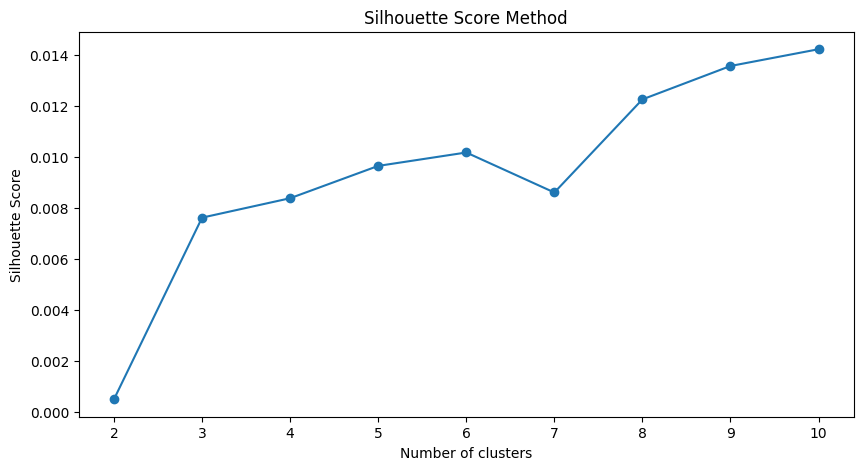

In [ ]:
# Silhouette Score
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()